# AirMSPI Dynamic Radiance data loading

This notebook demonstrates how to load data from AirMSPI's files. 

A pre-processing is applied on the data for the cloud reconstruction optimization.

---


The source Fortran code was created by Frank Evans and it is part of the SHDOM package: http://nit.colorado.edu/shdom.html

The python wrapper was created by Aviad Levis, Technion Inst. of Technology 2019: https://github.com/aviadlevis/pyshdom

In [1]:
"""
Imports necessary for this notebook
"""
import matplotlib.pyplot as plt
import copy
import numpy as np
import shdom
import glob


# Set data directory
# data_dir = '../AirMSPI/AirMSPI_ER2_GRP_ELLIPSOID_20130206_Pacific-32N123W'
# data_dir = '../AirMSPI/AirMSPI_ER2_GRP_ELLIPSOID_20130206_202514Z_NorthPacificOcean-32N123W'
data_dir = '../AirMSPI/21views'


format_ = '*.hdf'  # load
paths = sorted(glob.glob(data_dir + '/' + format_))
n_files = len(paths)

# pre-calculate region of interest for demonstration for 
# AirMSPI_ER2_GRP_ELLIPSOID_20130206_Pacific-32N123W data
# roi = [[1288, 1608, 588, 835], [1356, 1680, 640, 892], [1416, 1756, 696, 940], [1480, 1820, 732, 992], [1540, 1884, 792, 1036], [1604, 1944, 828, 1085], [1660, 2012, 884, 1140], [1728, 2084, 936, 1190], [1792, 2152, 980, 1255]]
import scipy.io as sio
roi_21 = sio.loadmat('../AirMSPI/21views/roi21.mat')
roi_21 = roi_21['roi21']
# roi_21 = roi_21[0:8].tolist()+roi_21[13:].tolist()
# roi_21 = roi_21[[0,1,2,3]].tolist()

In [2]:
%matplotlib inline

roi = roi_21[[11]]
valid_wavelength = [660]
airmspi_measurements = shdom.AirMSPIDynamicMeasurements()
airmspi_measurements.load_from_hdf(data_dir,region_of_interest=roi,valid_wavelength=valid_wavelength)

Data at path=../AirMSPI/21views/AirMSPI_ER2_GRP_ELLIPSOID_20130203_215806Z_CA-Nicasio_110A_F01_V005.hdf has invalid region of interest


In [3]:
# airmspi_measurements.calc_cloud_base_height(3,[1388, 1802],[1376, 1718])

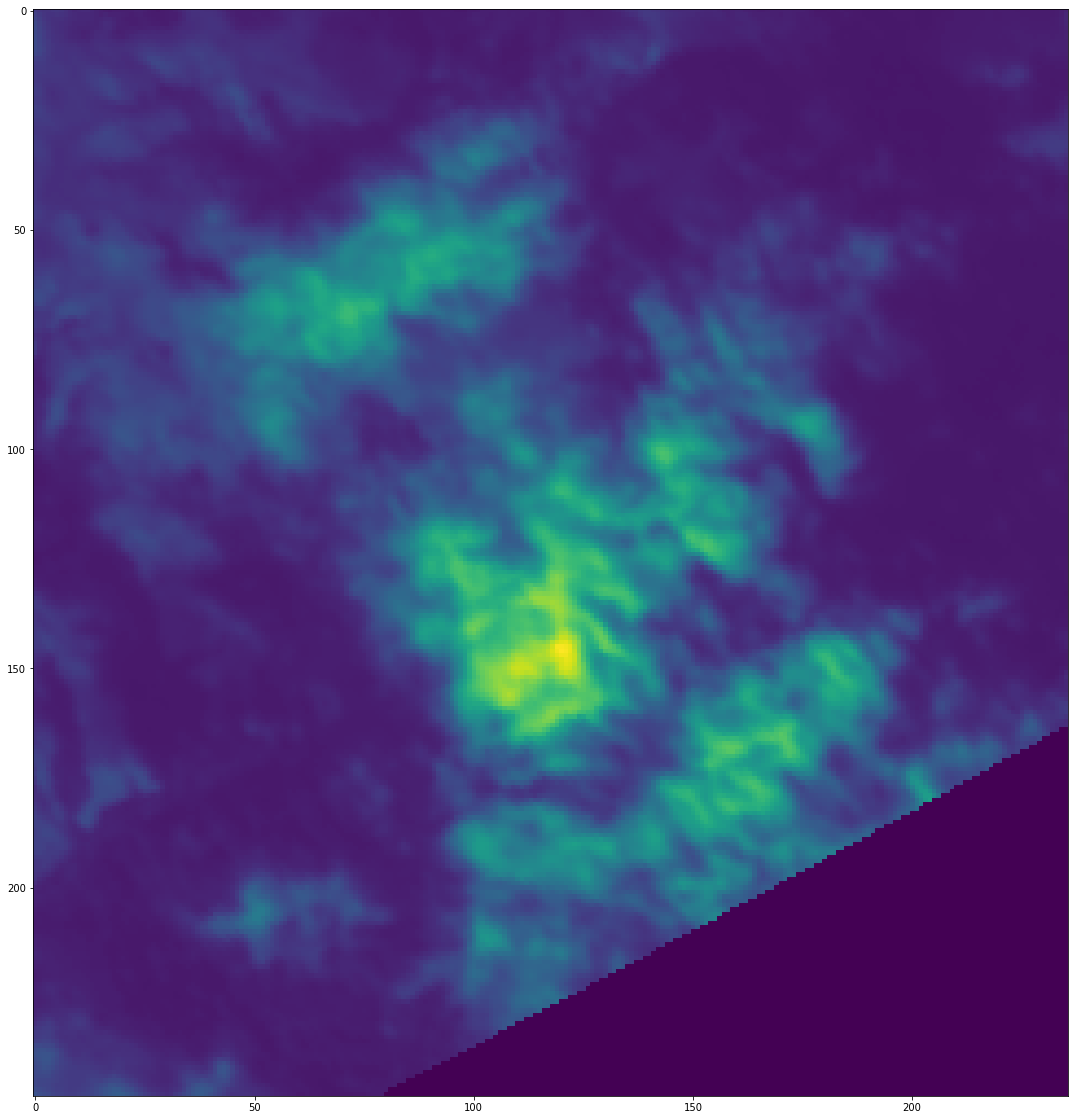

In [4]:
# View images
from skimage import filters

%matplotlib inline
f, axarr = plt.subplots(1, len(airmspi_measurements.images), figsize=(20, 20))
if isinstance(axarr,plt.Axes):
    axarr = [axarr]
for ax, image in zip(axarr,  copy.deepcopy(airmspi_measurements.images)):
    if len(image.shape)>2 and image.shape[2]==2:
        image = np.concatenate((image,np.reshape(image[:,:,0],(image.shape[0],image.shape[1],1))*0),2)
    elif len(image.shape)>2 and image.shape[2]>3:
        image = image[:,:,0:2]
    # thr = filters.threshold_isodata(image)
    # im = copy.deepcopy(image)
    # im = im >thr
    ax.imshow(image)
    # ax.imshow(im)

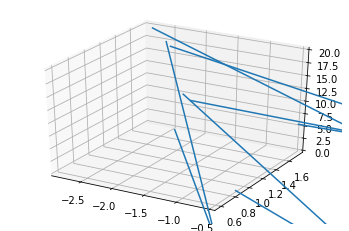

In [5]:
# Plot locations of the cameras

%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init()
x_min = airmspi_measurements._projections.x.min()
x_max = airmspi_measurements._projections.x.max()
y_min = airmspi_measurements._projections.y.min()
y_max = airmspi_measurements._projections.y.max()
airmspi_measurements.plot(ax,[x_min, x_max],[y_min, y_max],[0, 20],20)

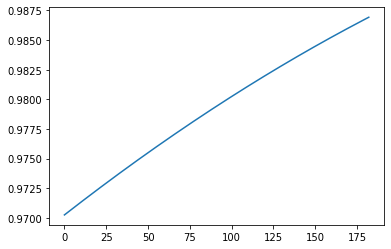

In [11]:
%matplotlib inline

pix = np.array(airmspi_measurements.camera.dynamic_projection.npix).ravel()
total_pix = np.sum(pix)
num_images = len(airmspi_measurements.images)
# split_indices = np.array(np.sum(measurements.camera.dynamic_projection.npix[:-1],axis=1)).ravel()
split_indices = np.cumsum(pix[:])
avg = len(split_indices) / float(1)
out = []
last = 0.0

while last < len(split_indices):
    out.append((split_indices[int(last + avg)-1]))
    last += avg
pix_mask_true = np.reshape(airmspi_measurements.pixels>0,(1,-1))
proj_x = airmspi_measurements.camera.dynamic_projection.phi 
# x = np.reshape(proj_x,airmspi_measurements.camera.dynamic_projection.resolution[0],order='F')<10
# y = np.reshape(pix_mask_true,airmspi_measurements.camera.dynamic_projection.resolution[0],order='F')
a= np.reshape( airmspi_measurements.camera.dynamic_projection.mu[:np.prod(airmspi_measurements.camera.dynamic_projection.resolution[0])],airmspi_measurements.camera.dynamic_projection.resolution[0],order='F')

mask = airmspi_measurements._mask_list[0][:,200]
a = a[:,200][mask]
plt.plot(a)

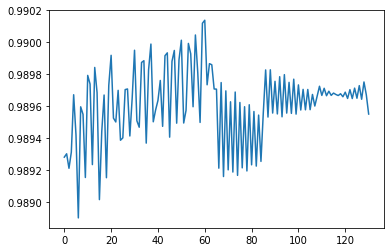

In [12]:
a= np.reshape( airmspi_measurements.camera.dynamic_projection.mu[:np.prod(airmspi_measurements.camera.dynamic_projection.resolution[0])],airmspi_measurements.camera.dynamic_projection.resolution[0],order='F')

mask = airmspi_measurements._mask_list[0][220,:]
a = a[220,:][mask]
plt.plot(a)
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# x,y = np.meshgrid(np.arange(a.shape[1]),np.arange(a.shape[0]))
# ax.plot_surface(x,y,a)
# ax.view_init(30, 90)
# plt.show()

# plt.imshow(x*1-y*1)
# plt.colorbar()
# pix_mask = np.array([],dtype=bool)
# for mask in airmspi_measurements._mask_list:
#     pix_mask = np.hstack((pix_mask,mask.ravel(order='F')))
# pix_mask = np.reshape(np.array([],dtype=bool),(1,-1))
# for im in airmspi_measurements.images:
#     mask = im >= 0
#     mask = np.reshape(mask,(1,-1))
#     pix_mask = np.hstack((pix_mask,mask))
# 
# masks = np.array_split(np.array(pix_mask), out[:-1])
# 